# ** Описание **

Построить графики распределения в спам и не спам множествах следующих признаков:

1	Количество слов на странице
2	Средняя длинна слова
3	Количество слов в заголовке страниц (слова в теге <html><head><title> Some text </title>)
4	Количество слов в анкорах ссылок (<html><body><a> Some text </a>)
5	Коэффициент сжатия

Нужно посчитать статистику минимум по трем признакам и обязательно сделать для 1-го и 2-го признаков

И отправить первое решение в соревнование https://kaggle.com/join/antispam_infopoisk
На основании одного из указанных выше признаков попытаться разделить мн-во, так чтобы score в соревновании был больше 0.55

При выполнении всех этих условия в течении семинара +1 балл к ДЗ

Описание ДЗ и правил выставления за него баллов в https://inclass.kaggle.com/c/antispam-infopoisk  
Сроки ДЗ уточнить у преподователя - обычно 2 недели

In [1]:
# SUPPORT PYTHON 2.7
import sys
if sys.version_info[0] >= 3:
    unicode = str

In [2]:
from __future__ import division

import base64
import csv
import gzip
import zlib

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
TRACE_NUM = 1000
import logging
#reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [4]:
def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [5]:
from html.parser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [6]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [7]:
html2text = html2text_bs

#### Методы для токенизации текста

In [8]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = unicode()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = unicode()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [9]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [10]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print ('threshold %s' % threshold)
            print ('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print ('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print ('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [11]:
!pip install nltk

In [12]:
#nltk.download('stopwords')
import nltk
from nltk.corpus import stopwords

# Ставим еще софтину

!pip install pymorphy2
!pip install -U pymorphy2-dicts-ru
import pymorphy2
!pip install -U pymorphy2-dicts-uk

nltk.download('stopwords')

Requirement already up-to-date: pymorphy2-dicts-ru in /home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages (2.4.404381.4453942)
Requirement already up-to-date: pymorphy2-dicts-uk in /home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages (2.4.1.1.1460299261)


[nltk_data] Downloading package stopwords to /home/rodion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
import numpy as np
from bs4 import BeautifulSoup

import tldextract
import re
    

def calc_features(url, html_data, mark):
    try:
        if not isinstance(html_data, str): html_data = html_data.decode('utf-8')
    except UnicodeDecodeError:
        print('UnicodeDecodeError')
        html_data = ""
    
    words = list(html2word(html_data))
    
    # feature 1
    words_num = len(words)
    
    # feature 2
    word_lens = np.array([len(word) for word in words], dtype=float)
    if len(word_lens) == 0:
        avg_word_len = 0
    else:
        avg_word_len = word_lens.mean()
    
    soup = BeautifulSoup(html_data, "html.parser")
    title = soup.find('title')
    # feature 3
    if title is None:
        title_words = ['']
        title_words_num = 0
    else:
        title_words = title.get_text().split()
        title_words_num = len(title_words)
    
    
    anchor = soup.find_all('a')
    links_num = 0
    if anchor is None:
        anchor_words_num = 0
    else:
        # feature 8
        links_num = len(anchor)
        anchor = np.array([len(a.text.split()) for a in anchor]).sum()
    # feature 4
    anchor_words_num = anchor
    
    # feature 5
    if len(html_data) == 0:
        compression_level = 0
    else:
        zip_data = zlib.compress(html_data.encode())
        compression_level = float(len(zip_data)) / float(len(html_data))
        
    # feature 6
    script_num = len(soup.find_all('script'))
    
    # feature 7
    img_num = len(soup.find_all('img'))
        
    # feature 8 DOT_IN_URL
    dots_in_url = url.count('.')
    
    # feature 9 URL_LEN
    url_len = len(url)
    
    # feature 10 Visible_Text_Percent
    visible_words_num = len(soup.get_text().split())
    if words_num == 0:
        visible_text_percent = 0
    else:
        visible_text_percent = float(visible_words_num) / float(words_num)
    
    # feature 11 slash in URL
    slash_in_url = url.count('/')
    
    # feature 12 CSS
    css_num = len(soup.find_all('link'))
    
    
    ## feature 13 Meta
    meta_num = len(soup.find_all('meta'))
    
    # feature 15 html in url
    html_in_url = int(url.endswith('html'))
    
   
    font_num = len(soup.find_all('font'))
    
    input_num = len(soup.find_all('input'))
    noindex_num = len(soup.find_all('noindex'))
    
   
    
  
    noscript_num = len(soup.find_all('noscript'))
  
    embed_num = len(soup.find_all('embed'))
    object_num = len(soup.find_all('object'))

    div_num = len(soup.find_all('div'))
    span_num = len(soup.find_all('span'))
    style_num = len(soup.find_all('style')) 
    form_num = len(soup.find_all('form'))
    
    
    url = list(tldextract.extract(url))
    
    
    return [words_num, 
            avg_word_len, 
            title_words_num, 
            anchor_words_num, 
            compression_level, 
            script_num,
            img_num,
            links_num, 
            dots_in_url, 
            url_len,
            visible_text_percent,
            slash_in_url, 
            css_num, 
            meta_num,
            html_in_url,
            font_num, input_num, noindex_num,
            noscript_num, embed_num, object_num,
            div_num, span_num, style_num, form_num,
            url]

In [14]:
test_html_data = u'''
<html>
<title> Заголовок Ololo проверяем это</title>
спам 1 2 3 the a to buy
<a>asffdf wekg</a>
<a>   fk </a>
Купить машину недорого
<script> </script>
<script> </script>
<link> </link>

<img> </img>
<meta http-equiv="Refresh"> </meta>
<meta> </meta>
<font> <option> <input> <section> <idxskip> <noindex>
<noscript> <time> <dfn>
</html>
'''
test_url =  'http://tipatiza.yc.cz/kak-pornoakteri-uvelichivayut-chlen-p13/gecub-100.html'
test_features = calc_features(test_url, test_html_data, True)
print(test_features)

[18, 4.111111111111111, 4, 3, 0.7958579881656804, 2, 1, 2, 3, 76, 1.0, 4, 1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ['tipatiza', 'yc', 'cz']]


In [15]:
from multiprocessing import Process, Queue
from tqdm import tqdm

from tqdm.notebook import tqdm_notebook

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

WORKER_NUM = 4

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in tqdm_notebook(enumerate(input_file)):
            trace(i)
            parts = line.strip().decode().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data, mark)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)  
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in tqdm_notebook(enumerate(input_file)):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
            parts = line.strip().decode().split('\t') # decode()!!!!!!!!!
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data, mark)            
            res_queue.put(DocItem(url_id, mark, url, features))
                
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)
        
def load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()    
    for i in range(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [16]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab_new.csv.gz'
# TRAIN_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features))

23:37:11 INFO:Complete items 00000
23:38:25 INFO:Complete items 01000
23:39:24 INFO:Complete items 02000
23:40:28 INFO:Complete items 03000


UnicodeDecodeError


23:41:29 INFO:Complete items 04000
23:42:41 INFO:Complete items 05000
23:43:48 INFO:Complete items 06000
23:44:52 INFO:Complete items 07000
23:44:55 INFO:Complete items 07043



CPU times: user 7min 43s, sys: 936 ms, total: 7min 44s
Wall time: 7min 44s


In [17]:
len(train_docs[2].features)


26

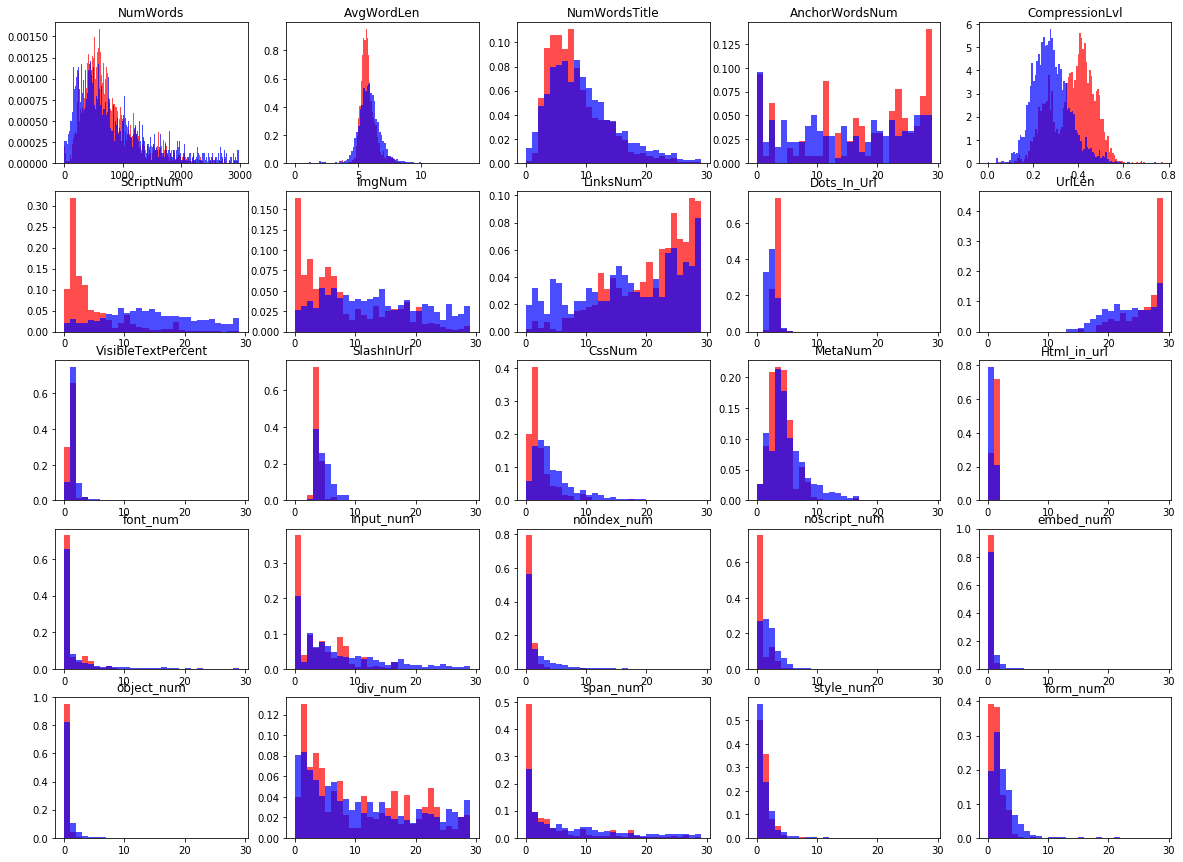

In [18]:
labels = ['NumWords', 'AvgWordLen', 'NumWordsTitle', 'AnchorWordsNum', 'CompressionLvl', 
          'ScriptNum', 'ImgNum', 'LinksNum', 'Dots_In_Url', 'UrlLen',
          'VisibleTextPercent', 'SlashInUrl', 'CssNum', 'MetaNum', 'Html_in_url',
          'font_num', 'input_num', 'noindex_num', 'noscript_num', 'embed_num', 
          'object_num', 'div_num', 'span_num', 'style_num', 'form_num']
plt.figure(figsize=(20, 15))

for i in range(25):
    is_spam_data = [doc.features[i] for doc in train_docs if doc[1] == True]
    not_spam_data = [doc.features[i] for doc in train_docs if doc[1] == False]
    bins = range(0,30,1)
    if labels[i] == 'NumWords':
        bins = range(0,3000,10)
    elif labels[i] == 'AvgWordLen' or labels[i] == 'CompressionLvl':
        bins = 100
    plt.subplot(5, 5, i+1)
    
    plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
    plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
    plt.title('{}'.format(labels[i]))

In [74]:
###########(Выше показано, как были получены признаки + урлы)
###########(Сейчас загружаю из файла, т.к. долго считается)
train_docs = np.load('train_docs_98_3.npz', allow_pickle=True)['arr_0']
train_docs[2]

array([-9219733223042265364, False,
       'http://www.ferio.ru/c_1-acura-legend.html',
       list([1203, 5.13383208645054, 6, 288, 0.2287361719891463, 14, 5, 138, 3, 41, 0.9783873649210307, 3, 3, 9, 1, 67, 0, 6, 2, 0, 0, 18, 1, 0, 0, ['www', 'ferio', 'ru']])],
      dtype=object)

In [84]:
train_docs = [DocItem._make(doc) for doc in train_docs]
train_docs[2]

DocItem(doc_id=-9219733223042265364, is_spam=False, url='http://www.ferio.ru/c_1-acura-legend.html', features=[1203, 5.13383208645054, 6, 288, 0.2287361719891463, 14, 5, 138, 3, 41, 0.9783873649210307, 3, 3, 9, 1, 67, 0, 6, 2, 0, 0, 18, 1, 0, 0, ['www', 'ferio', 'ru']])

In [19]:
######### Валидация по классификатору URL
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

url_tokens = [doc.features[-1] for doc in train_docs]
train_targets = [doc.is_spam for doc in train_docs]

def dummy_fun(doc):
    return doc

vectorizer_url = TfidfVectorizer(analyzer='word', 
                             tokenizer=dummy_fun,
                             preprocessor=dummy_fun,
                             token_pattern=None, ngram_range=(1,2))


train_url_vectorized = vectorizer_url.fit_transform(url_tokens)

url_classifier = LogisticRegression(C=1000)

from sklearn.model_selection import cross_validate
np.mean(cross_validate(url_classifier, train_url_vectorized, train_targets, cv=5)['test_score'])

/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9637987733079555

In [20]:
##### Обучение классификатора URL
url_classifier.fit(train_url_vectorized, train_targets)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
##### Немного статистики
from collections import Counter

aggregate_counter = Counter()
for tok, doc in zip(url_tokens, train_docs):
    if doc[1] == True:
        aggregate_counter += Counter(tok)

common_words = [word[0] for word in aggregate_counter.most_common(15)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(15)]

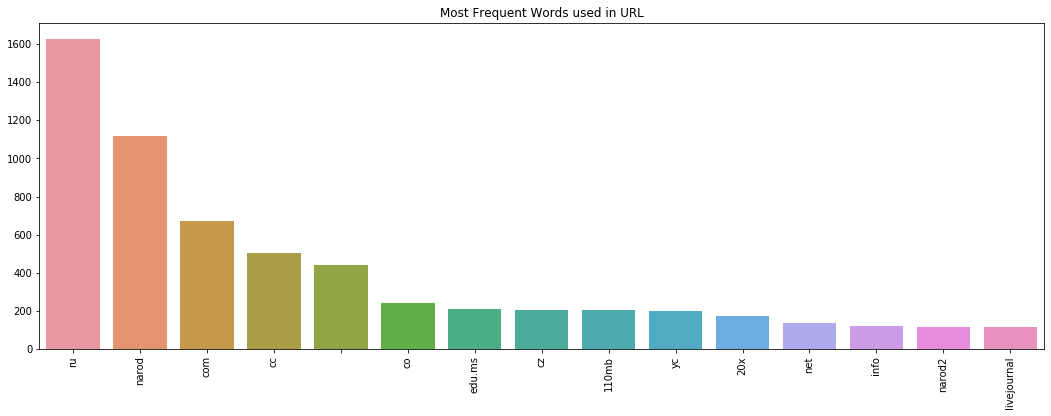

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()
barplot(words=common_words, words_counts=common_words_counts, title='Most Frequent Words used in URL')

** Классификатор: **
Нужно реализовать

In [23]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import OneClassSVM

import xgboost as xgb
from xgboost import XGBClassifier
class Classifier:
    def __init__(self):
        self.clf = XGBClassifier()
        
    def predict(self, doc):
        return self.clf.predict_proba(np.array(doc.features[:-1]).reshape(1, -1))                 
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def train(self, docs):                
        features = np.array([doc.features[:-1] for doc in docs]).astype("float32")
        targets =  np.array([doc.is_spam for doc in docs]).astype("float32")
        features = np.nan_to_num(features)
        targets = np.nan_to_num(targets)

        self.clf = self.clf.fit(features, targets)

    def cross_validation(self, docs):
        from sklearn.model_selection import StratifiedKFold
        features = np.array([doc.features[:-1] for doc in docs]).astype("float32")
        targets =  np.array([doc.is_spam for doc in docs]).astype("float32")
        
        
        skf = StratifiedKFold(n_splits=5)
        scores = []
        for train_index, test_index in skf.split(features, targets):
            X_tr, X_tt = features[train_index], features[test_index]
            y_tr, y_tt = targets[train_index], targets[test_index]
            self.clf.fit(X_tr, y_tr)
            y_pred = self.clf.predict(X_tt)
            scores.append(f1_score(y_tt, y_pred))
        return scores
         

In [24]:
##### Валидация основного классификатора
classifier = Classifier()
np.mean(classifier.cross_validation(train_docs))

0.9714788402714529

In [25]:
###### Обучение основного классификатора
classifier = Classifier()
classifier.train(train_docs)

In [ ]:
###### Так парсились тексты
import numpy as np
from bs4 import BeautifulSoup

def calc_texts(url, html_data, mark):
    try:
        if not isinstance(html_data, str): html_data = html_data.decode('utf-8')
    except UnicodeDecodeError:
        print('UnicodeDecodeError')
        html_data = ""
    soup = BeautifulSoup(html_data, "html.parser")
    words = pymorphy_tokenizer(soup.get_text())
    words = [word for word in words if word not in stopwords.words('russian') and word not in stopwords.words('english')]
    return words


TRAIN_DATA_FILE  = 'kaggle_train_data_tab_new.csv.gz'

train_texts = list(load_csv(TRAIN_DATA_FILE, extract_text))

In [26]:
train_texts = np.load('train_texts.npz', allow_pickle=True)['arr_0']
train_texts[20][:5]

['сотовый', 'телефон', 'купить', 'цена', 'top']

In [27]:
##### Так обрабатывались тексты
##### Валидация по классификатору текстов
def dummy_fun(tok):
    return tok
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
vectorizer_texts = TfidfVectorizer(analyzer='word', 
                             tokenizer=dummy_fun,
                             preprocessor=dummy_fun,
                             token_pattern=None, ngram_range=(1,2))

text_classifier = LogisticRegression(C=20)
train_text_vectorized = vectorizer_texts.fit_transform(train_texts)
np.mean(cross_validate(text_classifier, train_text_vectorized, train_targets)['test_score'])

/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9704715617153861

In [28]:
##### Обучение классификатора текстов
text_classifier.fit(train_text_vectorized, train_targets)

LogisticRegression(C=20, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
####### Вот так и будет выглядеть финальная модель
train_xgb_pred = np.array([doc[3][0][1] for doc in classifier.predict_all(train_docs)])
train_url_pred = url_classifier.predict_proba(train_url_vectorized)[:, 1]
train_text_pred = text_classifier.predict_proba(train_text_vectorized)[:, 1]

final_train_pred = np.array((train_xgb_pred + train_url_pred + train_text_pred) / 3 >= 0.5, dtype=int)
f1_score(final_train_pred, train_targets)

23:49:49 INFO:Complete items 00000
23:49:49 INFO:Complete items 01000
23:49:49 INFO:Complete items 02000
23:49:49 INFO:Complete items 03000
23:49:50 INFO:Complete items 04000
23:49:50 INFO:Complete items 05000
23:49:50 INFO:Complete items 06000
23:49:50 INFO:Complete items 07000


1.0

In [55]:
%%time
TEST_DATA_FILE  = 'kaggle_test_data_tab_new.csv.gz'
# TEST_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

test_docs = list(load_csv(TEST_DATA_FILE, calc_features))


22:26:57 INFO:Complete items 00000
22:29:11 INFO:Complete items 01000
22:31:18 INFO:Complete items 02000
22:32:32 INFO:Complete items 03000
22:33:39 INFO:Complete items 04000
22:34:42 INFO:Complete items 05000
22:36:48 INFO:Complete items 06000
22:37:56 INFO:Complete items 07000
22:39:04 INFO:Complete items 08000
22:40:17 INFO:Complete items 09000
22:42:40 INFO:Complete items 10000
22:43:50 INFO:Complete items 11000
22:45:07 INFO:Complete items 12000
22:46:13 INFO:Complete items 13000
22:47:27 INFO:Complete items 14000
22:48:40 INFO:Complete items 15000
22:50:02 INFO:Complete items 16000
22:50:05 INFO:Complete items 16038



CPU times: user 23min 8s, sys: 1.58 s, total: 23min 9s
Wall time: 23min 8s


In [30]:
#### Сверху показано, как считалось
#### Сейчас просто загружаем предпосчитанное
test_docs = np.load('test_docs_98_3.npz', allow_pickle=True)['arr_0']
test_docs = [DocItem._make(doc) for doc in test_docs]
test_docs[2]

DocItem(doc_id=-9216634615606576667, is_spam=True, url='http://petropavl.kz/whouse/autor/autor4.shtml', features=[241, 5.941908713692946, 13, 16, 0.37169983092729875, 14, 20, 21, 2, 45, 1.7095435684647302, 5, 3, 4, 1, 0, 5, 0, 1, 0, 0, 20, 0, 1, 1, ['', 'petropavl', 'kz']])

In [31]:
###### Предсказание основного классификатора
xgb_test_predictions = np.array([doc[3][0][1] for doc in classifier.predict_all(test_docs)])
xgb_test_predictions.shape

23:49:59 INFO:Complete items 00000
23:50:00 INFO:Complete items 01000
23:50:00 INFO:Complete items 02000
23:50:00 INFO:Complete items 03000
23:50:00 INFO:Complete items 04000
23:50:01 INFO:Complete items 05000
23:50:01 INFO:Complete items 06000
23:50:01 INFO:Complete items 07000
23:50:01 INFO:Complete items 08000
23:50:02 INFO:Complete items 09000
23:50:02 INFO:Complete items 10000
23:50:02 INFO:Complete items 11000
23:50:02 INFO:Complete items 12000
23:50:02 INFO:Complete items 13000
23:50:03 INFO:Complete items 14000
23:50:03 INFO:Complete items 15000
23:50:03 INFO:Complete items 16000


(16039,)

In [32]:
url_test_tokens = [doc.features[-1] for doc in test_docs]

test_url_vectorized = vectorizer_url.transform(url_test_tokens)
test_url_vectorized

<16039x15851 sparse matrix of type '<class 'numpy.float64'>'
	with 39934 stored elements in Compressed Sparse Row format>

In [33]:
###### Предсказание классификатора URL
url_test_predictions = url_classifier.predict_proba(test_url_vectorized)[:, 1]
url_test_predictions.shape

(16039,)

In [ ]:
##### Так парсились тексты
TEST_DATA_FILE  = 'kaggle_test_data_tab_new.csv.gz'

test_texts = list(load_csv(TEST_DATA_FILE, calc_texts))


In [34]:
test_texts = np.load('test_texts.npz', allow_pickle=True)['arr_0']
test_texts_vectorized = vectorizer_texts.transform(test_texts)
test_texts_vectorized

<16039x4894711 sparse matrix of type '<class 'numpy.float64'>'
	with 18287248 stored elements in Compressed Sparse Row format>

In [35]:
###### Предсказание классификатора текстов
text_test_predictions = text_classifier.predict_proba(test_texts_vectorized)[:, 1]
text_test_predictions.shape

(16039,)

In [36]:
############### Эталонное предсказание классисфикатора текстов
text_test_predictions = np.load('TEXT_PREDICTION2.npz', allow_pickle=True)['arr_0'][:, 1]
text_test_predictions.shape
###############

(16039,)

In [37]:
final_test_predictions = np.array((xgb_test_predictions +\
                                   url_test_predictions +\
                                   text_test_predictions) / 3 >= 0.5, dtype=int)
np.unique(final_test_predictions, return_counts=True)

(array([0, 1]), array([7982, 8057]))

In [39]:
import pandas as pd
doc_ids = [doc[0] for doc in test_docs]
subm = {'Id': doc_ids, 'Prediction': final_test_predictions}

submission_df = pd.DataFrame(subm, columns=['Id', 'Prediction'])
submission_df.to_csv('qqqq_subm_urls+text+xgb+meta_tag_feature+endswithhtml+new_tag_features3_more_than_1dot5.csv', index=None)

###### Далее просто песочница, разные идеи


In [116]:
# (array([0, 1]), array([7873, 8166]))
# (array([0, 1]), array([7901, 8138])) # 98_233
# (array([0, 1]), array([7892, 8147])) # 97_195
# (array([0, 1]), array([7900, 8139])) # 98_145
# 7945 # 98_671


16039

In [55]:
import pickle
pickle.dump(text_classifier ,open('text_classifier.sav', 'wb'))

In [60]:
loaded_model = pickle.load(open('text_classifier.sav', 'rb'))
loaded_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:

pickle.dump(url_classifier ,open('url_classifier.sav', 'wb'))

In [57]:

pickle.dump(classifier ,open('xgb_classifier.sav', 'wb'))

In [53]:
# ends_with_html: 0.97944 --> 0.98233

In [58]:
np.savez('train_docs_98_2.npz', train_docs)
np.savez('test_docs_98_2.npz', test_docs)

### В поисках новых идей посмотрим распределение тегов

In [89]:
import numpy as np
from bs4 import BeautifulSoup

import tldextract
import re
from collections import defaultdict

spam_tags = defaultdict(int)
normal_tags = defaultdict(int)
def calc_tags(url, html_data, mark):
    try:
        if not isinstance(html_data, str): html_data = html_data.decode('utf-8')
    except UnicodeDecodeError:
        print('UnicodeDecodeError')
        html_data = ""
    
    
    soup = BeautifulSoup(html_data, "html.parser")
    
    if mark == True:
        for tag in soup.find_all():
            spam_tags[tag.name] += 1
    else:
        for tag in soup.find_all():
            normal_tags[tag.name] += 1
    return

In [90]:
def load_csv_small(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in tqdm_notebook(enumerate(input_file)):
            trace(i)
            parts = line.strip().decode().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data, mark)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)  
        

In [91]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab_new.csv.gz'
# TRAIN_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

train_tags = list(load_csv_small(TRAIN_DATA_FILE, calc_tags))

23:39:54 INFO:Complete items 00000
23:40:22 INFO:Complete items 01000
23:40:47 INFO:Complete items 02000
23:41:16 INFO:Complete items 03000


UnicodeDecodeError


23:41:43 INFO:Complete items 04000
23:42:16 INFO:Complete items 05000
23:42:44 INFO:Complete items 06000
23:43:10 INFO:Complete items 07000
23:43:11 INFO:Complete items 07043



CPU times: user 3min 16s, sys: 416 ms, total: 3min 17s
Wall time: 3min 17s


In [82]:
train_targets_small = [doc.is_spam for doc in train_docs]
len(train_targets_small)

7044

In [83]:
np.unique(train_targets, return_counts=True)

(array([False,  True]), array([2935, 4109]))

<BarContainer object of 20 artists>

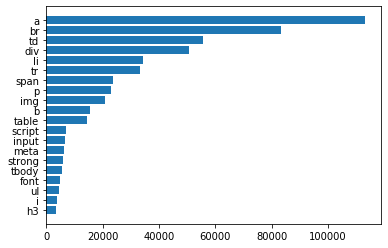

In [84]:
plt.barh(*zip(*sorted(spam_tags.items(), key=lambda x: x[1])[-20:]))

In [241]:
tag_dict = [(key, spam_tags[key], normal_tags[key]) for key in spam_tags.keys() & normal_tags.keys() 
 if spam_tags[key] > 100 or normal_tags[key] > 100]
tag_dict

[('link', 8116, 13318),
 ('sub', 0, 517),
 ('td', 128233, 291635),
 ('font', 10890, 40723),
 ('form', 3941, 6457),
 ('p', 53232, 89014),
 ('script', 16525, 52495),
 ('u', 907, 3410),
 ('blockquote', 348, 1306),
 ('fieldset', 671, 548),
 ('html', 4044, 2971),
 ('table', 32878, 50267),
 ('tbody', 12213, 3893),
 ('iframe', 743, 1485),
 ('sup', 105, 1892),
 ('b', 35889, 61417),
 ('dt', 937, 1276),
 ('option', 5281, 47586),
 ('select', 261, 1608),
 ('em', 6985, 3121),
 ('nobr', 488, 4008),
 ('param', 797, 4639),
 ('img', 49243, 132717),
 ('button', 18, 1014),
 ('section', 338, 22),
 ('li', 77514, 104531),
 ('optgroup', 0, 209),
 ('spacer', 434, 781),
 ('br', 197234, 238804),
 ('base', 256, 375),
 ('th', 2739, 3912),
 ('small', 2103, 3882),
 ('body', 4147, 3050),
 ('tr', 76288, 139274),
 ('o:p', 630, 2681),
 ('textarea', 1066, 1077),
 ('hr', 1684, 8886),
 ('ins', 687, 1902),
 ('h3', 9109, 7620),
 ('article', 335, 178),
 ('span', 42649, 111684),
 ('title', 4108, 2942),
 ('idxskip', 907, 1),
 

In [242]:
# выделяется font, option, idxskip, input, ('address', 12, 159), ('font', 4726, 15491)
# ('select', 128, 762)
# ('legend', 9, 122)
# ('noindex', 628, 4899)
# embed, object
# cite
# iframe
# param

In [245]:
sorted([(key, spam_tags[key] / (normal_tags[key] + 1)) for key in spam_tags.keys() & normal_tags.keys()], key=lambda x: x[1])

[('rdf:description', 0.0),
 ('sape_index', 0.0),
 ('sub', 0.0),
 ('main_content_block_marker__begin', 0.0),
 ('pun_navlinks', 0.0),
 ('kbd', 0.0),
 ('ooo', 0.0),
 ('main_content_block_marker__form_end', 0.0),
 ('string', 0.0),
 ('e', 0.0),
 ('news', 0.0),
 ('format', 0.0),
 ('main_content_block_marker__exclusion_2_end', 0.0),
 ('tel', 0.0),
 ('blink', 0.0),
 ('script="javascript"', 0.0),
 ('ilayer', 0.0),
 ('h7', 0.0),
 ('main_content_block_marker__form_begin', 0.0),
 ('pl', 0.0),
 ('script1', 0.0),
 ('fb:recommendations', 0.0),
 ('align=left', 0.0),
 ('if="threaded', 0.0),
 ('loop', 0.0),
 ('smallll', 0.0),
 ('noembed', 0.0),
 ('main_content_block_marker__end', 0.0),
 ('img<br', 0.0),
 ('mdend', 0.0),
 ('mlp_navigation_menu_item_start', 0.0),
 ('font=#ffffff', 0.0),
 ('if', 0.0),
 ('v:imagedata', 0.0),
 ('size="5"', 0.0),
 ('hide', 0.0),
 ('fb:share-button', 0.0),
 ('optgroup', 0.0),
 ('nolayers', 0.0),
 ('xeanon_uk4x5065y1vrd5fw01pnme36i0cltt', 0.0),
 ('fb:fan', 0.0),
 ('spec_mark', 